# **1. Import Libraries**

In [54]:
# Data Analysis
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import math
import random
import warnings
from collections import Counter
plt.style.use('ggplot')
# Ignore warnings
warnings.filterwarnings('ignore')

# TensorFlow
import tensorflow as tf
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2


# Sci-kit learn

## Model building
from sklearn.model_selection import train_test_split

## Metrics to evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

## Handle class imbalance
from sklearn.utils import class_weight

import pickle
import shap

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
# Directories
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "val")

In [ ]:
# Allow reproducability
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# **2. Data Analysis**

## **2.1 Image Count Analysis**

In [ ]:
# Count images in each category
data_counts = {}
for split in ['train', 'test', 'val']:
  split_dir = os.path.join(base_dir, split)
  data_counts[split] = {}

  for category in ['NORMAL', 'PNEUMONIA']:
    category_dir = os.path.join(split_dir, category)
    if os.path.exists(category_dir):
      num_images = len(os.listdir(category_dir))
      data_counts[split][category] = num_images
      print(f"{split} / {category}: {num_images} images")
    else:
      data_counts[split][category] = 0

train / NORMAL: 1342 images
train / PNEUMONIA: 3876 images
test / NORMAL: 234 images
test / PNEUMONIA: 390 images
val / NORMAL: 9 images
val / PNEUMONIA: 9 images


## **2.2 Class Distribution Analysis**

In [ ]:
def view_class_distribution(data_counts):
  """
  Displays class distributions for a folder
  """
  plt.pie(data_counts, labels=['Normal', 'Pneumonia'], autopct='%1.1f%%',
          colors=['#2ecc71', '#e74c3c'], startangle=90, explode=(0.05, 0))
  plt.title(f'Class Distribution (n = {sum(data_counts)})')
  plt.show()

In [ ]:
# Get each counts for each folder
train_counts = [data_counts['train']['NORMAL'], data_counts['train']['PNEUMONIA']]
test_counts = [data_counts['test']['NORMAL'], data_counts['test']['PNEUMONIA']]
val_counts = [data_counts['val']['NORMAL'], data_counts['val']['PNEUMONIA']]

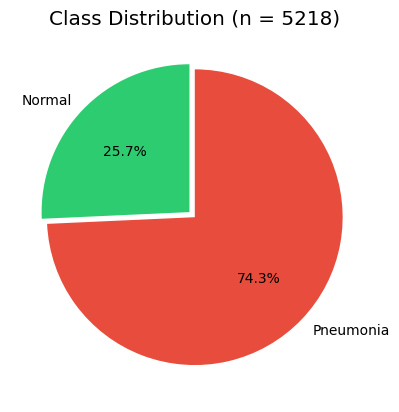

In [ ]:
# Train distribution
view_class_distribution(train_counts)

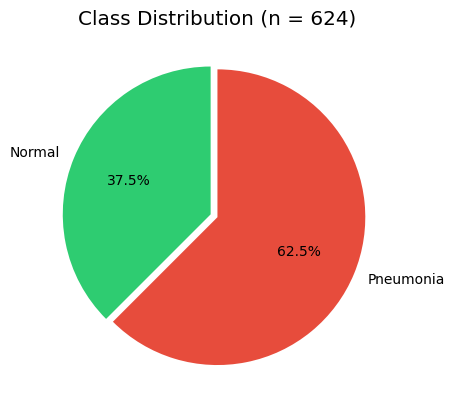

In [ ]:
# Test distribution
view_class_distribution(test_counts)

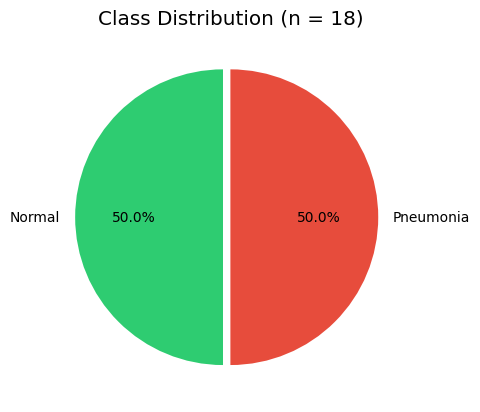

In [ ]:
# Validation distribution
view_class_distribution(val_counts)

## **2.3 Imbalance Ratio Analysis**

In [ ]:
# Divide pneumonia train counts with normal train counts
ratio = data_counts['train']['PNEUMONIA'] / data_counts['train']['NORMAL']
print(f"Class Imbalance Ratio: {ratio:.3f}")

Class Imbalance Ratio: 2.888


## **2.4 Image Analysis**

In [ ]:
samples = []

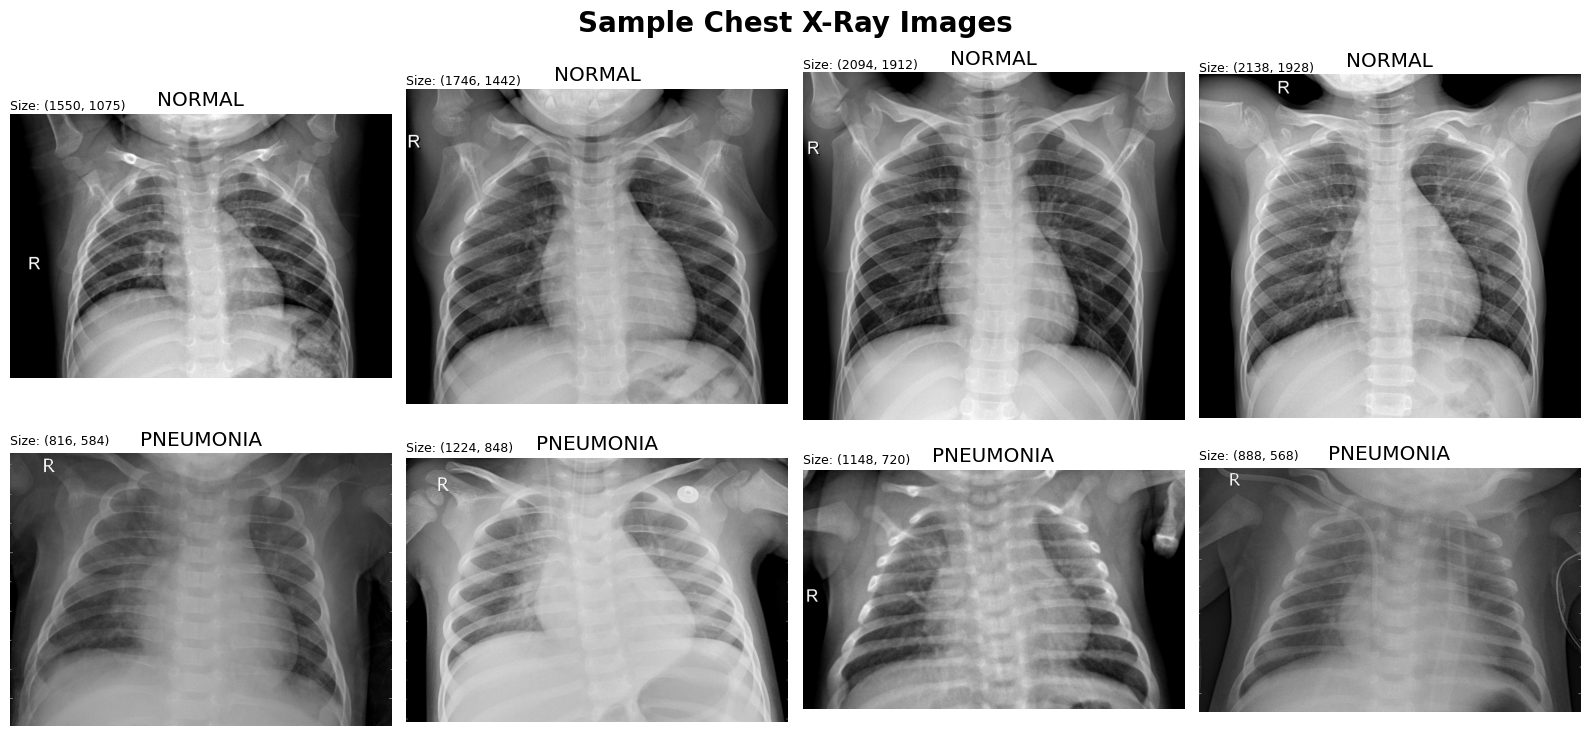

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(16,8))

for label in ['NORMAL', 'PNEUMONIA']:
  label_path = os.path.join(train_dir, label)
  img_files = [f for f in os.listdir(label_path) if f.endswith(('.jpeg', '.jpg'))]

  # Random 4 samples (filenames) for the current label
  selected_filenames = random.sample(img_files, 4)

  for img_file_name in selected_filenames:
    img_path = os.path.join(label_path, img_file_name)
    img = Image.open(img_path)
    samples.append((img, label))

# Display samples
for i, tup in enumerate(samples):
  row = i // 4
  col = i % 4

  axes[row, col].imshow(tup[0], cmap='gray')
  axes[row, col].set_title(tup[1])
  axes[row, col].axis('off')

  axes[row, col].text(0, -20, f'Size: {tup[0].size}', fontsize=9)

plt.suptitle('Sample Chest X-Ray Images', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

## **2.5 Dimension Analysis**

In [ ]:
# Prepare a dimensions array to store all dimensions
dimensions = []

# Append first 50 image dimensions per category
for category in ['NORMAL', 'PNEUMONIA']:
  category_dir = os.path.join(train_dir, category)
  image_files = [f for f in os.listdir(category_dir) if f.endswith(('.jpeg', '.jpg'))]

  # First 50 images
  for img_file in image_files[:50]:
    path = os.path.join(category_dir, img_file)
    img = Image.open(path)
    dimensions.append(img.size)

In [ ]:
dimensions = np.array(dimensions)

In [ ]:
dimensions

array([[1336, 1128],
       [1400, 1260],
       [1218, 1032],
       [1782, 1433],
       [1574, 1129],
       [1744, 1345],
       [1844, 1272],
       [1500, 1249],
       [2400, 2121],
       [1338, 1102],
       [1160,  904],
       [1804, 1510],
       [1488, 1017],
       [1636, 1329],
       [1802, 1422],
       [1932, 1908],
       [1580, 1410],
       [1576, 1272],
       [1542, 1461],
       [1472,  978],
       [1676, 1391],
       [1402, 1105],
       [1690, 1383],
       [1692, 1221],
       [2358, 1959],
       [1754, 1178],
       [1546, 1399],
       [1848, 1588],
       [2018, 1920],
       [1014,  846],
       [1894, 1688],
       [1790, 1600],
       [1272, 1048],
       [1696, 1298],
       [1704, 1341],
       [1630, 1353],
       [1732, 1662],
       [1700, 1271],
       [1690, 1334],
       [1186,  940],
       [1620, 1340],
       [1462, 1140],
       [1792, 1611],
       [1724, 1422],
       [1512, 1302],
       [1314, 1171],
       [1330, 1133],
       [1164,

In [ ]:
# Unique dimensions
np.unique(dimensions)

array([ 457,  488,  504,  516,  544,  562,  568,  624,  632,  648,  656,
        672,  680,  703,  712,  717,  736,  744,  752,  768,  776,  808,
        824,  829,  832,  840,  846,  856,  880,  884,  895,  896,  904,
        920,  928,  940,  976,  978,  984, 1010, 1014, 1016, 1017, 1021,
       1024, 1032, 1044, 1048, 1072, 1080, 1084, 1094, 1102, 1105, 1112,
       1120, 1128, 1129, 1133, 1140, 1144, 1149, 1152, 1160, 1164, 1171,
       1176, 1178, 1184, 1186, 1208, 1218, 1221, 1240, 1248, 1249, 1256,
       1260, 1271, 1272, 1298, 1302, 1314, 1328, 1329, 1330, 1334, 1336,
       1338, 1340, 1341, 1345, 1353, 1368, 1376, 1380, 1381, 1383, 1391,
       1392, 1399, 1400, 1402, 1408, 1410, 1422, 1424, 1428, 1433, 1456,
       1461, 1462, 1472, 1488, 1500, 1510, 1512, 1518, 1528, 1542, 1546,
       1555, 1574, 1576, 1580, 1588, 1600, 1611, 1620, 1630, 1636, 1662,
       1676, 1688, 1690, 1692, 1696, 1700, 1704, 1724, 1732, 1744, 1754,
       1782, 1790, 1792, 1802, 1804, 1844, 1848, 18

In [ ]:
# Maximum dimensions
np.max(dimensions, axis=0)

array([2400, 2121])

In [ ]:
# Minimum dimension
np.min(dimensions, axis=0)

array([703, 457])

In [ ]:
# Average
np.mean(dimensions, axis=0)

array([1407.31, 1092.98])

# **3. Data Preprocessing**

## **3.1 Preprocessing Function**

In [ ]:
def preprocess(img):
  """
  Applies medical image specific preprocessing
  - CLAHE for contrast enhancement
  - Normalization
  - Grayscaling
  """
  # Conver to grayscale if RGB
  if img.ndim == 3:
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  else:
    img_gray = img

  # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) - enhances local contrast by dividing images into tiles
  # Performs hisotgram equalization for each tile
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img_enhanced = clahe.apply(img_gray.astype(np.uint8))

  # Normalize to [0, 1]
  img_normalized = img_enhanced.astype(np.float32) / 255.0

  if img_normalized.ndim == 2:
    img_normalized = np.stack([img_normalized] * 3, axis=-1)

  return img_normalized

## **3.2 What is CLAHE?**

It is an image preprocessing technique used to help improve the contrast of images (GeeksforGeeks, 2025)

The way it works:



1.   Division of Tiles: The image is split into small, non-overlapping tiles
2.   Local Histogram Calculation: A histogram is computed for each tile
3. Contrast Limiting: A clip limit is set, and if a histogram bin exceeds this limit, then excess pixels are redistributed to other bins, thus preventing noise amplification
4. Bilinear Interpolation: These contrast adjusted tiles are then stitched back together using bilinear interpolation for smooth transitions


**Bilinear interpolation will perform linear interpolation twice, on the x-direction then the y-direction. Useful for grid type data. It resizes images by calculating new pixel values using a weighted average of the four nearest pixels, hence making images smoother.**


## **3.3 Data Generators**

In [ ]:
# Train data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [ ]:
# val and test generators but no augmentation
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess
)

In [ ]:
# Define target size and batch size
target_size = (224, 224)
batch_size = 32

In [ ]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

# Valid generator
val_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# View information
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Classes: {train_generator.class_indices}")

Training samples: 5216
Validation samples: 16
Test samples: 624
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


## **3.4 Class Imbalance Handling using Class Weights**

In [ ]:
# Get class counts with the total number of samples
class_counts = Counter(train_generator.classes)
total_samples = sum(class_counts.values())

In [ ]:
# Check for the class weights
class_weights = {}

for class_idx, count in class_counts.items():
  class_weights[class_idx] = total_samples / (len(class_counts) * count)

In [ ]:
# Display them
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int32(1): 3875, np.int32(0): 1341})
Class weights: {np.int32(0): 1.9448173005219984, np.int32(1): 0.6730322580645162}


## **3.5 Visualize Augmented Samples**

In [ ]:
# Prepare images + labels with class names
images, labels = next(train_generator)
class_names = {v: k for k, v in train_generator.class_indices.items()}

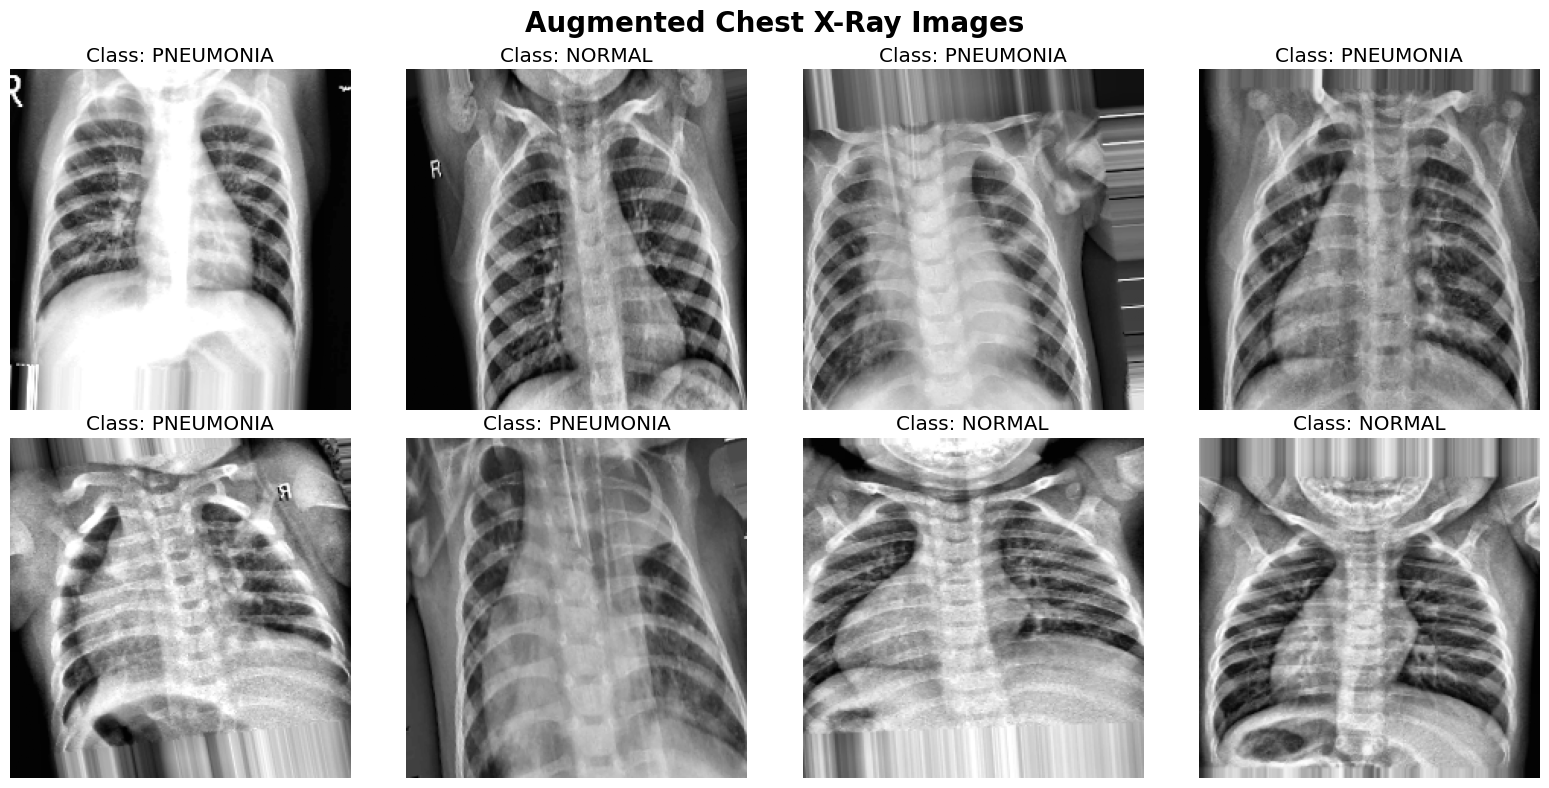

In [ ]:
# Visualize the augmented samples
fig, axes = plt.subplots(2,4, figsize=(16,8))
for i in range(8):
  ax = axes[i//4, i%4]
  ax.imshow(images[i])
  ax.set_title(f"Class: {class_names[int(labels[i])]}")
  ax.axis('off')

plt.suptitle('Augmented Chest X-Ray Images', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# **4. Synthetic Data Generation**

## **4.1 Define Synthetic Generators**

In [ ]:
# Synthetic data generator
synthetic_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=30.0,
    fill_mode='reflect'
)

In [ ]:
# Synthetic train generator
synthetic_train_generator = synthetic_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

Found 5216 images belonging to 2 classes.


Augmentations done:



1.   Rotation by 20 degrees
2.   Width/Height shift by 15%
3. Shear by 15%
4. Zoom by 25%
5. Horizontal & Vertical flip
6. Brightness variation between 70% and 130%
7. Channel shift
8. CLAHE preprocessing done


## **4.2 Plot a Few Samples**

In [ ]:
# Demonstrating the synthetic data generation
sample_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
sample_img = Image.open(sample_img_path).convert('RGB').resize(target_size)
sample_array = np.expand_dims(np.array(sample_img), axis=0)

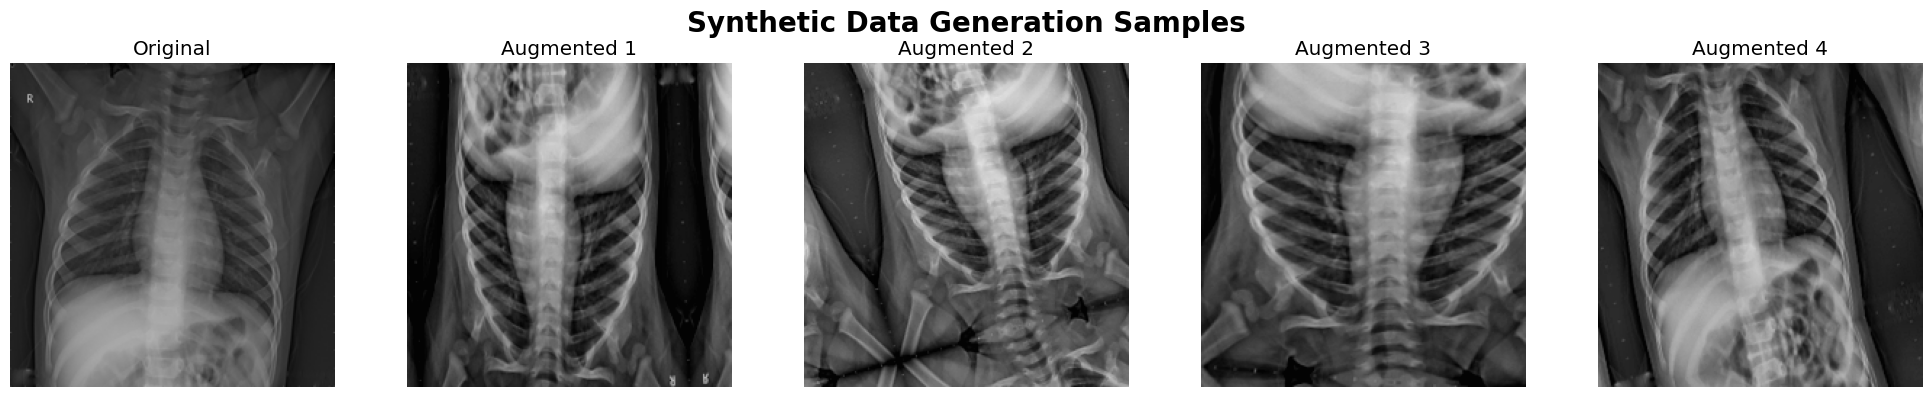

In [ ]:
# Prepare for plotting
fig, axes = plt.subplots(1,5, figsize=(20,4))

# Show original
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Generate and show augmented versions
for i in range(4):
  for batch in synthetic_datagen.flow(sample_array, batch_size=1):
    augmented_img = (batch[0] * 255).astype('uint8')
    axes[i+1].imshow(augmented_img, cmap='gray')
    axes[i+1].set_title(f'Augmented {i+1}')
    axes[i+1].axis('off')
    break # would loop forever

plt.suptitle('Synthetic Data Generation Samples', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# **5. Model Building**

In [ ]:
# Load pre-trained DenseNet121
densenet_base = DenseNet121(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3)
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base model layers
densenet_base.trainable = False

In [ ]:
# Build model on top of it
densenet_model = Sequential([
    densenet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
    ]
)

In [ ]:
# Compile the model
densenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

In [ ]:
# Summary of the model
densenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,334,465 (27.98 MB)

 Trainable params: 296,193 (1.13 MB)

 Non-trainable params: 7,038,272 (26.85 MB)

# **6. Model Training**

## **6.1 Define Early Stopping**

In [ ]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

## **6.2 Train DenseNet121**

In [ ]:
# Use checkpoints to save the best model
model_checkpoint_densenet = ModelCheckpoint(
    'base_densenet.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# Callbacks to prevent overfitting
densenet_callbacks = [early_stopping, model_checkpoint_densenet]

In [ ]:
# Store in a history variable for later plotting of metrics
densenet_history = densenet_model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=densenet_callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8036 - auc: 0.9235 - loss: 0.3791 - precision: 0.9662 - recall: 0.7618
Epoch 1: val_auc improved from -inf to 0.99219, saving model to base_densenet.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 962s 6s/step - accuracy: 0.8040 - auc: 0.9237 - loss: 0.3787 - precision: 0.9662 - recall: 0.7622 - val_accuracy: 0.8125 - val_auc: 0.9922 - val_loss: 0.5726 - val_precision: 1.0000 - val_recall: 0.6250
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9149 - auc: 0.9706 - loss: 0.2250 - precision: 0.9743 - recall: 0.9093
Epoch 2: val_auc did not improve from 0.99219
163/163 ━━━━━━━━━━━━━━━━━━━━ 961s 6s/step - accuracy: 0.9149 - auc: 0.9707 - loss: 0.2248 - precision: 0.9743 - recall: 0.9094 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.3293 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9242 - auc: 0.9789 - loss: 0.1875 - precision: 0.9789 - recall: 0.919

In [ ]:
# Base model
with open('base_history.pkl', 'wb') as f:
    pickle.dump(densenet_history.history, f)

# **7. Model Evaluation**

## **7.1 Metrics Function**

In [ ]:
def plot_curves(model, title):
  """
  Plots the metrics of a given model history
  """
  # Prepare plotting
  fig, axes = plt.subplots(2, 3, figsize=(18,10))

  plt.suptitle(f'History Metrics for {title}', fontweight='bold', fontsize=21)

  # Accuracy
  axes[0, 0].plot(model.history['accuracy'], label=f'Training Accuracy', c='r')
  axes[0, 0].plot(model.history['val_accuracy'], label=f'Validation Accuracy', c='b')
  axes[0, 0].set_title(f'{title} - Accuracy')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('Accuracy')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # Loss
  axes[0, 1].plot(model.history['loss'], label='Training Loss', c='r')
  axes[0, 1].plot(model.history['val_loss'], label='Validation Loss', c='b')
  axes[0, 1].set_title(f'{title} - Loss')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Loss')
  axes[0, 1].legend()
  axes[0, 1].grid(True, alpha=0.3)

  # Precision
  axes[0, 2].plot(model.history['precision'], label='Training Precision', c='r')
  axes[0, 2].plot(model.history['val_precision'], label='Validation Precision', c='b')
  axes[0, 2].set_title(f'{title} - Precision')
  axes[0, 2].set_xlabel('Epoch')
  axes[0, 2].set_ylabel('Precision')
  axes[0, 2].legend()
  axes[0, 2].grid(True, alpha=0.3)

  # Recall
  axes[1, 0].plot(model.history['recall'], label='Training Recall', c='r')
  axes[1, 0].plot(model.history['val_recall'], label='Validation Recall', c='b')
  axes[1, 0].set_title(f'{title} - Recall')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].set_ylabel('Recall')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # AUC
  axes[1, 1].plot(model.history['auc'], label='Training AUC', c='r')
  axes[1, 1].plot(model.history['val_auc'], label='Validation AUC', c='b')
  axes[1, 1].set_title(f'{title} - AUC')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('AUC')
  axes[1, 1].legend()
  axes[1, 1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

## **7.2 Base Model Curves**

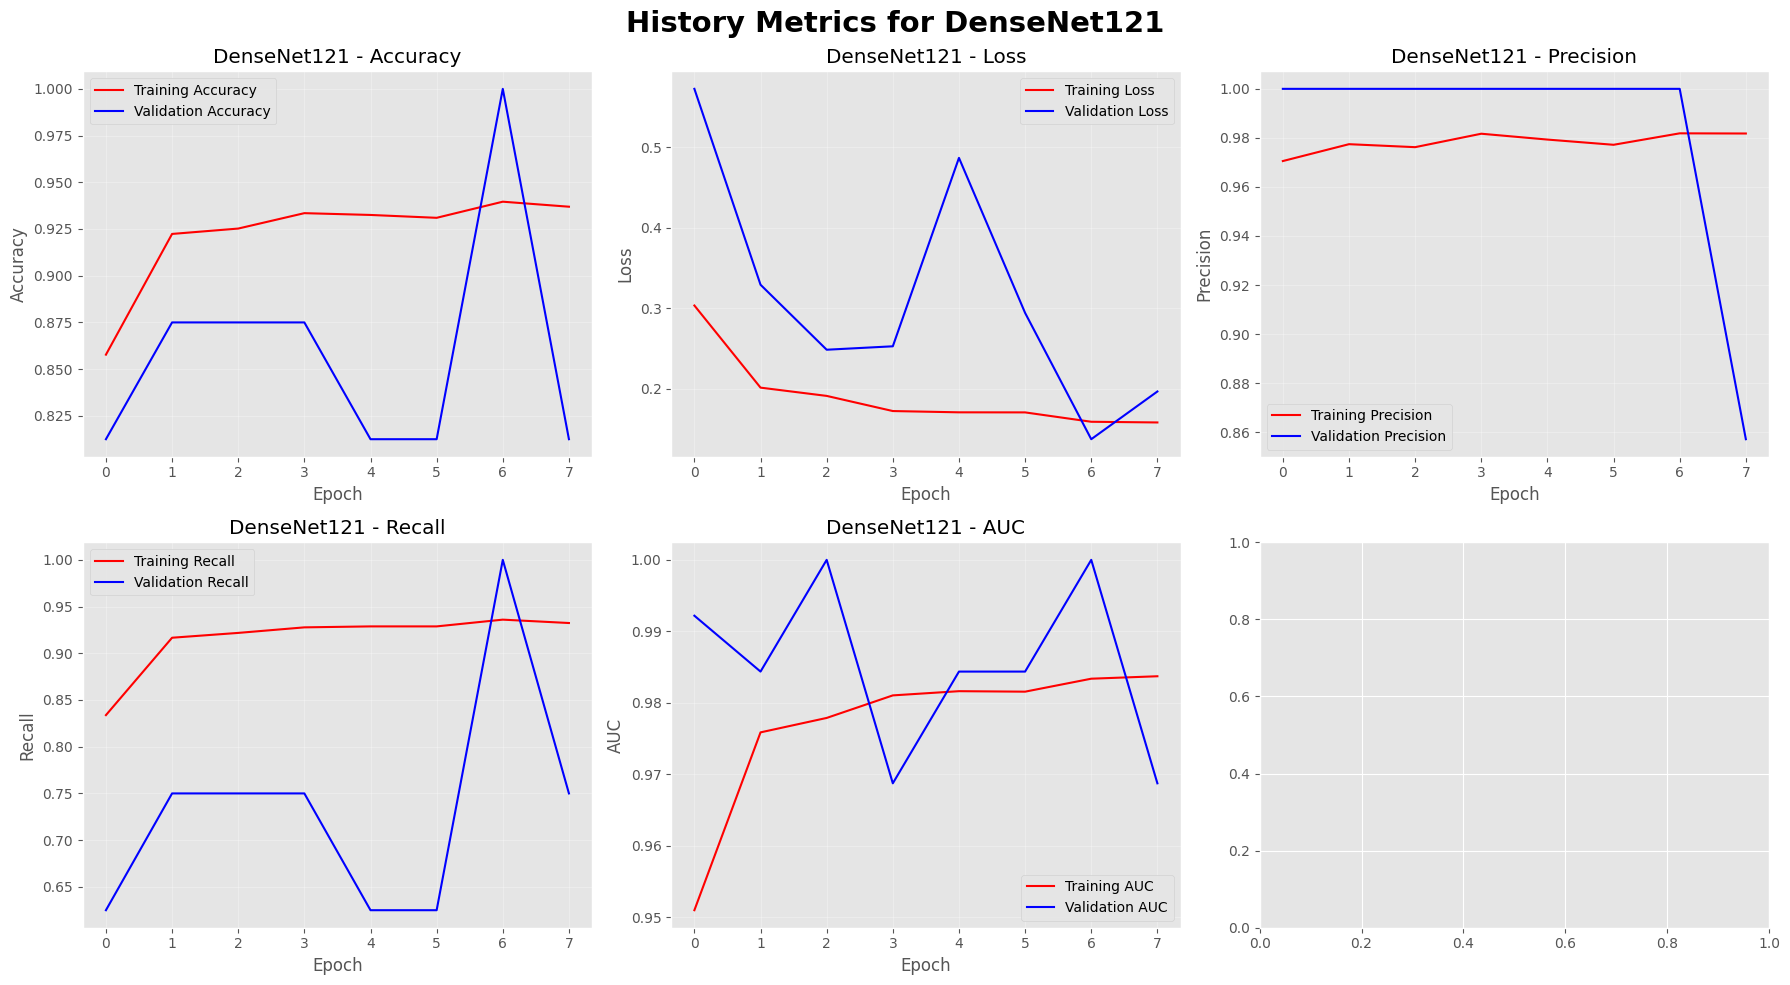

In [ ]:
# Curves for the base model
plot_curves(densenet_history, 'DenseNet121')

In [ ]:
# All plotted metrics
metrics = ['accuracy', 'precision', 'recall', 'auc', 'loss']

In [ ]:
# Loop through the metrics
for metric in metrics:
  if metric == "loss":
    print(f"Best Validation {metric.capitalize()}: {round(min(densenet_history.history[f'val_{metric}']), 4)}")
  else:
    print(f"Best Validation {metric.capitalize()}: {round(max(densenet_history.history[f'val_{metric}']), 4)}")

Best Validation Accuracy: 1.0
Best Validation Precision: 1.0
Best Validation Recall: 1.0
Best Validation Auc: 1.0
Best Validation Loss: 0.1373


In [ ]:
# Get predictions and probabilities
test_generator.reset()
base_test_results = densenet_model.evaluate(test_generator, verbose=1)
base_predictions = densenet_model.predict(test_generator, verbose=1)
base_pred_classes = (base_predictions > 0.5).astype(int)
base_pred_proba = base_predictions.flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.8890 - auc: 0.6341 - loss: 0.2556 - precision: 0.5539 - recall: 0.5707
20/20 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step


In [ ]:
# Get true labels
test_generator.reset()
y_true = test_generator.classes

## **7.3 Base Model Evaluation**

In [ ]:
def get_metrics(y_true, y_pred, y_pred_proba, model_name):

  # Classification report
  report = classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'])

  # Confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

  # ROC AUC
  fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
  roc_auc = auc(fpr, tpr)

  # Store in a dictionary for easy access
  metrics = {
      'model': model_name,
      'classification_report': report,
      'confusion_matrix': cm,
      'confusion_matrix_disp': disp,
      'roc_auc': roc_auc
  }

  return metrics

In [ ]:
# Receive the metrics dictionary
base_metrics = get_metrics(y_true, base_pred_classes, base_pred_proba, 'DenseNet121')

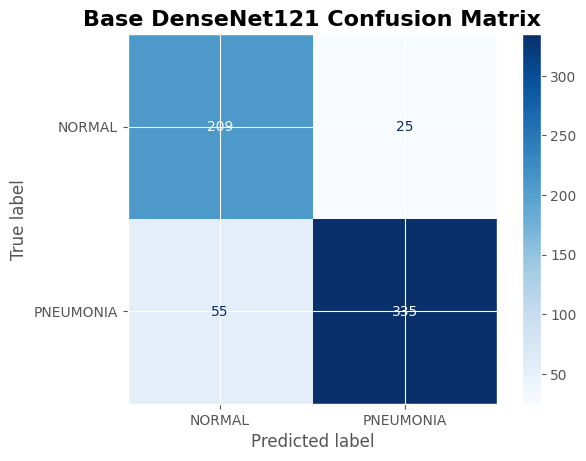

In [ ]:
# View confusion matrix
base_metrics['confusion_matrix_disp'].plot(cmap=plt.cm.Blues)
plt.title('Base DenseNet121 Confusion Matrix', fontweight='bold', fontsize=16)
plt.show()

In [ ]:
# Classification report
print(base_metrics['classification_report'])

              precision    recall  f1-score   support

      NORMAL       0.79      0.89      0.84       234
   PNEUMONIA       0.93      0.86      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.88      0.87      0.87       624



In [ ]:
# ROC AUC
print("ROC AUC score:", base_metrics['roc_auc'])

ROC AUC score: 0.9553911900065747


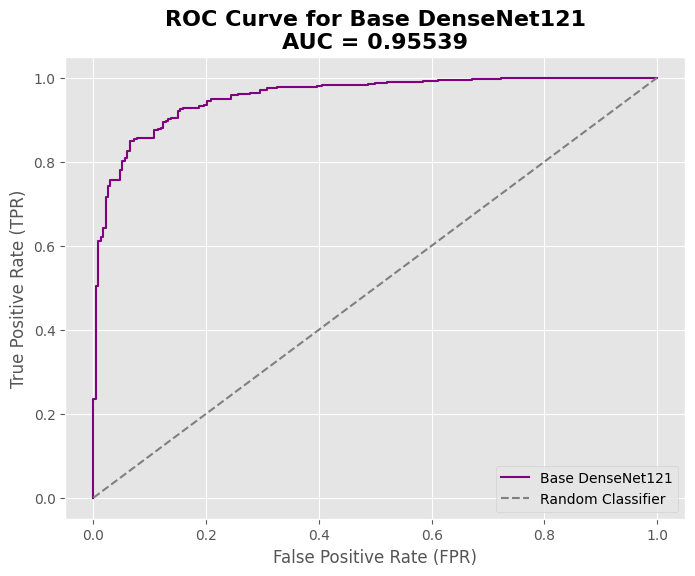

In [ ]:
# ROC curve plotting for base model
fpr, tpr, _ = roc_curve(y_true, base_pred_proba)

# Plot the curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, c='purple', label='Base DenseNet121')
plt.plot([0,1], [0,1], c='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for Base DenseNet121\nAUC = {base_metrics['roc_auc']:.5f}', fontweight='bold', fontsize=16)
plt.legend()
plt.show()

# **8. Hyperparameter Tuning**

## **8.1 Compile and Unfreeze Layers**

In [ ]:
# Unfreeze some layers
for layer in densenet_model.layers[-50:]:
  layer.trainable = True

In [ ]:
# Compile
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

In [ ]:
# Summary
densenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,334,465 (27.98 MB)

 Trainable params: 7,250,049 (27.66 MB)

 Non-trainable params: 84,416 (329.75 KB)

## **8.2 Train Best Model**

In [ ]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

In [ ]:
# Use checkpoints to save the best model
best_checkpoint_densenet = ModelCheckpoint(
    'best_densenet.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# Callbacks to prevent overfitting
best_densenet_callbacks = [early_stopping, best_checkpoint_densenet]

In [ ]:
# Store in a history variable for later plotting of metrics
best_densenet_history = densenet_model.fit(
    train_generator,
    epochs=9,
    validation_data=val_generator,
    callbacks=best_densenet_callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/9
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.8623 - auc: 0.9267 - loss: 0.3794 - precision: 0.9351 - recall: 0.8769 
Epoch 1: val_auc improved from -inf to 1.00000, saving model to best_densenet.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 4101s 25s/step - accuracy: 0.8625 - auc: 0.9269 - loss: 0.3789 - precision: 0.9352 - recall: 0.8769 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.3154 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 2/9
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9157 - auc: 0.9741 - loss: 0.2126 - precision: 0.9724 - recall: 0.9117 
Epoch 2: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━━━━━━━━━━ 3783s 23s/step - accuracy: 0.9158 - auc: 0.9741 - loss: 0.2125 - precision: 0.9724 - recall: 0.9117 - val_accuracy: 0.6250 - val_auc: 0.9297 - val_loss: 1.3626 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 3/9
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9375 - auc: 0.9815 - loss: 0.1758 - precision: 0.9839 - recall:

In [ ]:
# Save tuned history aswell
with open('tuned_history.pkl', 'wb') as f:
    pickle.dump(best_densenet_history.history, f)

# **9. Best Model Evaluation**

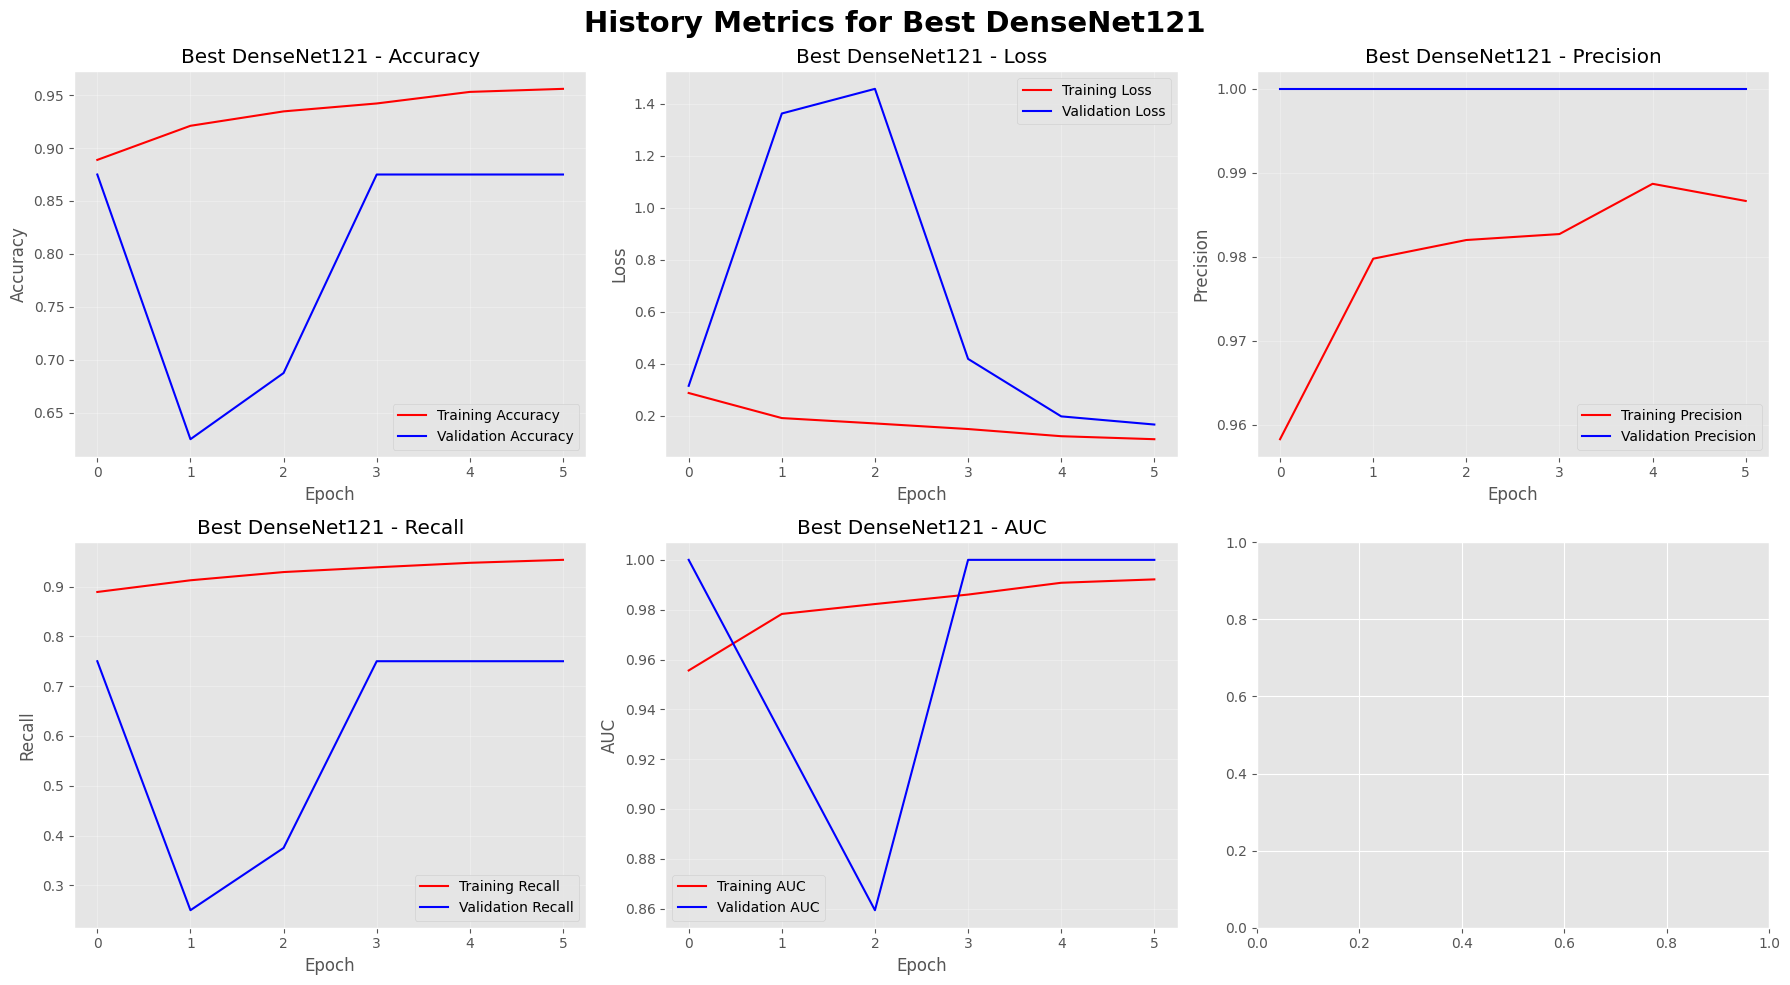

In [ ]:
# Curves for the base model
plot_curves(best_densenet_history, 'Best DenseNet121')

In [ ]:
# All plotted metrics
metrics = ['accuracy', 'precision', 'recall', 'auc', 'loss']

In [ ]:
# Loop through the metrics
for metric in metrics:
  if metric == "loss":
    print(f"Best Validation {metric.capitalize()}: {round(min(best_densenet_history.history[f'val_{metric}']), 4)}")
  else:
    print(f"Best Validation {metric.capitalize()}: {round(max(best_densenet_history.history[f'val_{metric}']), 4)}")

Best Validation Accuracy: 0.875
Best Validation Precision: 1.0
Best Validation Recall: 0.75
Best Validation Auc: 1.0
Best Validation Loss: 0.1666


In [ ]:
# Get predictions and probabilities
test_generator.reset()
best_test_results = densenet_model.evaluate(test_generator, verbose=1)
best_predictions = densenet_model.predict(test_generator, verbose=1)
best_pred_classes = (best_predictions > 0.5).astype(int)
best_pred_proba = best_predictions.flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.9216 - auc: 0.6395 - loss: 0.2315 - precision: 0.6029 - recall: 0.5680
20/20 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step


In [ ]:
# Get true labels
test_generator.reset()
y_true = test_generator.classes

In [ ]:
# Receive the metrics dictionary
best_metrics = get_metrics(y_true, best_pred_classes, best_pred_proba, 'Best DenseNet121')

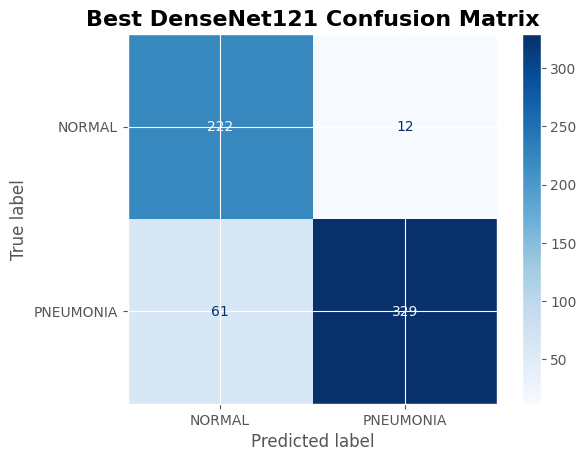

In [ ]:
# View confusion matrix
best_metrics['confusion_matrix_disp'].plot(cmap=plt.cm.Blues)
plt.title('Best DenseNet121 Confusion Matrix', fontweight='bold', fontsize=16)
plt.show()

In [ ]:
# Classification report
print(best_metrics['classification_report'])

              precision    recall  f1-score   support

      NORMAL       0.78      0.95      0.86       234
   PNEUMONIA       0.96      0.84      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.90      0.88       624
weighted avg       0.90      0.88      0.88       624



In [ ]:
# ROC AUC
print("ROC AUC score:", best_metrics['roc_auc'])

ROC AUC score: 0.9609686609686611


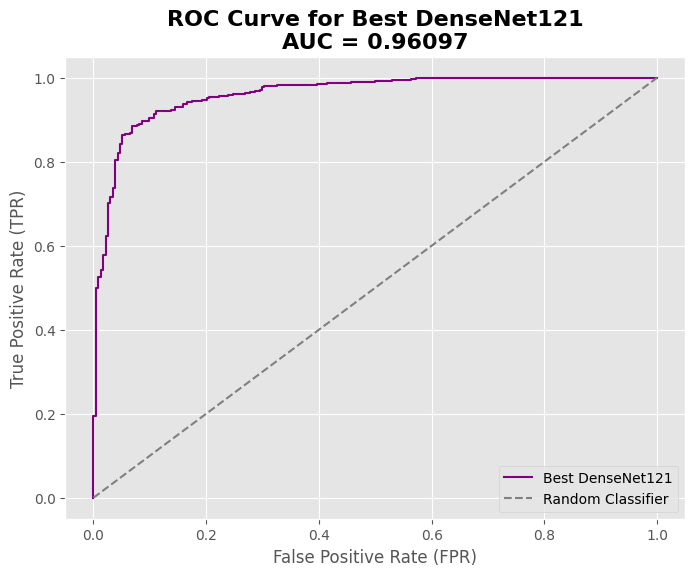

In [ ]:
# Prepare FPR and TPR for best model
fpr, tpr, _ = roc_curve(y_true, best_pred_proba)

# Plot ROC for best model
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, c='purple', label='Best DenseNet121')
plt.plot([0,1], [0,1], c='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for Best DenseNet121\nAUC = {best_metrics['roc_auc']:.5f}', fontweight='bold', fontsize=16)
plt.legend()
plt.show()

In [81]:
densenet_model = load_model('best_densenet.keras', compile=False)

In [82]:
def make_gradcam_heatmap(img_array, model_base, last_conv_layer_name):
  """
  Generate Grad-CAM heatmap for a single image

  Paramaters:
    img_array: (1, H, W, 3) preprocessed
    model_base: DenseNet121 model
    last_conv_layer_name: Name of the last convolutional layer in the model
    pred_index: Class index to visualize
  """

  last_conv_layer = model_base.get_layer(last_conv_layer_name)

  # Create a temporary model that outputs feature maps from the last conv layer + final prediction
  grad_model = Model(
      inputs=[model_base.inputs],
      outputs=[last_conv_layer.output, model_base.output]
  )

  with tf.GradientTape() as tape: # Record operations with this to compute gradients
    conv_outputs, predictions = grad_model(img_array)
    class_channel = predictions[:, 0]  # model output for class of interest

  grads = tape.gradient(class_channel, conv_outputs)  # gradient of predicted class wrt feature maps
  pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))  # importance weight per feature map
  conv_outputs = conv_outputs[0]
  heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  # where the model looked (weighted sum of feature maps)
  heatmap = tf.squeeze(heatmap)

  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # only positive influence shown, nornalize to [0, 1] for plotting
  return heatmap.numpy()

In [83]:
def superimpose_heatmap(img, heatmap, alpha=0.4, cmap='jet'):
  """
  Overlays heatmap on original image
  Parameters:
    img: numpy array (H,W,3)
    heatmap: numpy array (H,W)
    alpha: transparency
    cmap: Style to apply
  """

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # red = important
  superimposed_img = heatmap_color * alpha + img
  superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
  return superimposed_img

In [84]:
# Sequential model's base
densenet_base = densenet_model.layers[0]

In [85]:
last_conv_layer_name = 'conv5_block16_2_conv'

In [86]:
def plot_gradcam_for_batch(generator, model_seq, n_images=5):
  """
  Plots Grad-CAM heatmaps for the first n_images from the generator
  """

  class_names = ['NORMAL', 'PNEUMONIA']

  # Take a batch
  imgs, labels = next(iter(generator))

  n_images = min(n_images, imgs.shape[0])

  # Define rows and columns
  cols = 3
  rows = math.ceil(n_images / cols)

  fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
  axes = axes.flatten()

  for i in range(n_images):
    img_array = imgs[i:i+1] # (1, H, W, 3)
    true_label = class_names[int(labels[i])]

    # make predictions
    preds = model_seq.predict(img_array, verbose=0)
    prob = preds[0][0]

    pred_label = "PNEUMONIA" if prob >= 0.5 else "NORMAL"
    confidence = prob if pred_label == "PNEUMONIA" else 1 - prob
    confidence = round(confidence, 2)
    confidence *= 100

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, densenet_base, last_conv_layer_name)

    # Convert image to uint8 for overlay
    img_uint8 = np.uint8(img_array[0] * 255)  # since normalized to [0,1]

    # Overlay the heatmap
    superimposed_img = superimpose_heatmap(img_uint8, heatmap)

    ax = axes[i]

    # Plot
    ax.imshow(superimposed_img)
    ax.axis('off')

    title_color = "green" if pred_label == "NORMAL" else "RED"

    ax.set_title(
        f'Prediction: {pred_label}\nTrue Label: {true_label}\nConfidence: {confidence}',
        fontsize = 14,
        color = title_color,
    )

  # Hide unused subplots
  for j in range(i+1, len(axes)):
    axes[j].axis('off')

  # Set the title
  plt.suptitle(
      'Pneumonia Detection - Grad-CAM Explanations',
      fontsize=20,
      fontweight='bold'
  )

  plt.tight_layout(rect=[0,0,1,0.95])
  plt.show()

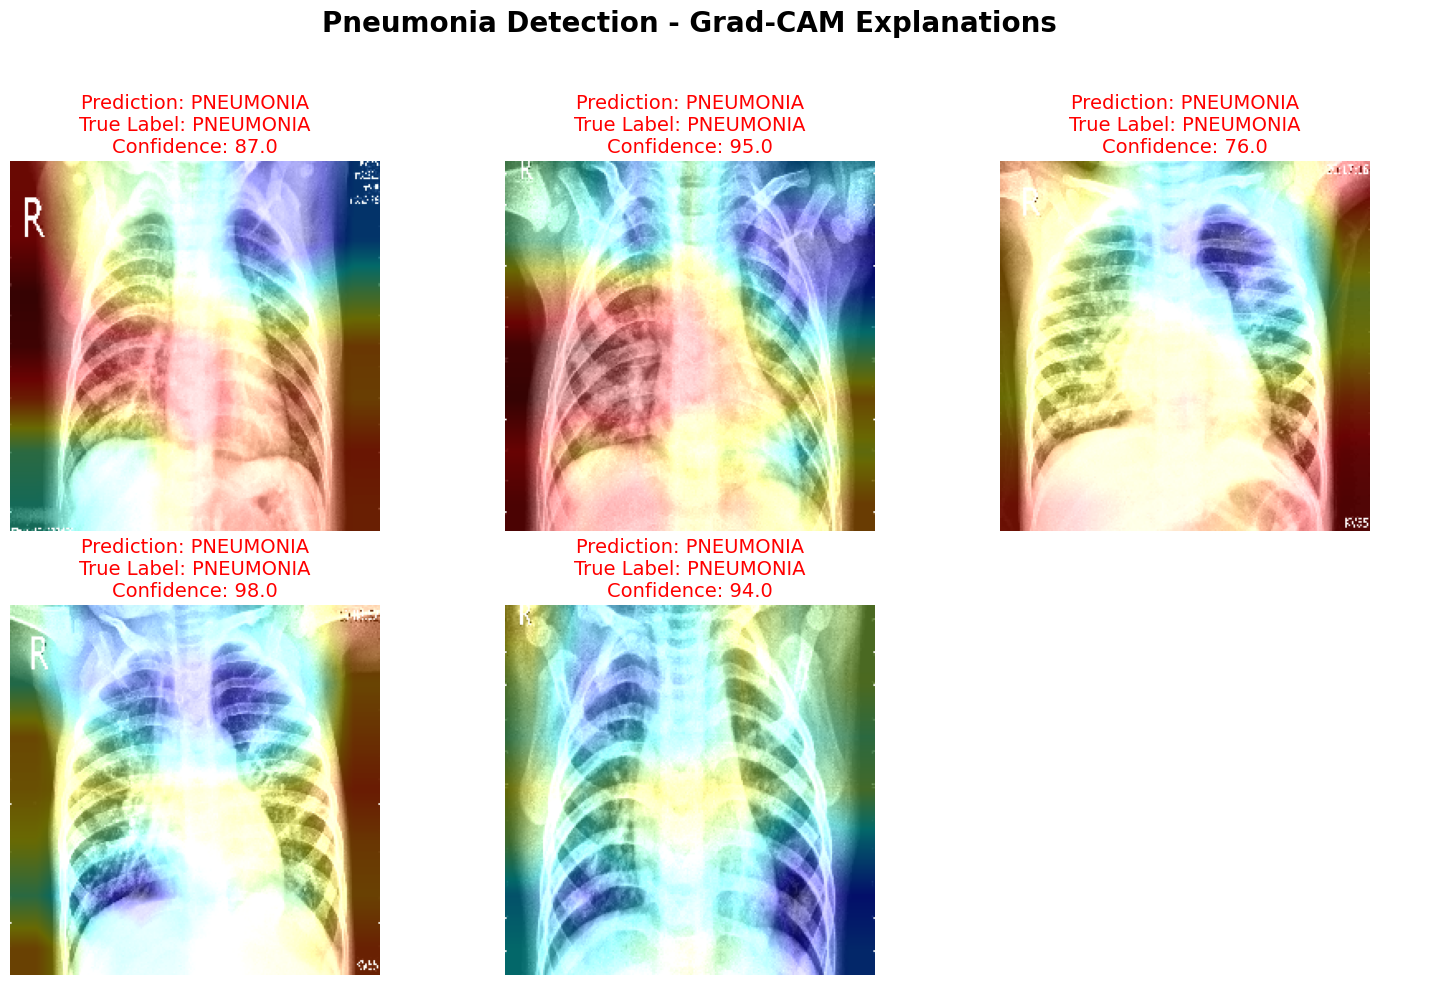

In [87]:
# Plot the gradcam for 5 images
plot_gradcam_for_batch(test_generator, densenet_model, n_images=5)